# Predicting Cancer Type from Single Cell RNA-Seq Data

## Baseline Model

### Elsa Bismuth & Jonathan Mathews

Updated On: 11/24/2022

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
MODELDIR = "/content/drive/My Drive/ML4FG_Project/"
DATADIR = "/content/drive/My Drive/ML4FG_Project/Data"

Mounted at /content/drive


# Import Statements

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

- Removes non-numeric data (due to mislabeling by database administrators)
- Only keeps common genes for each sample (found from Dataloader code)


In [ ]:
genesToUse = []
with open(MODELDIR + "Common_Genes.txt") as f:

  numGenes = int(f.readline())
  for line in f:

    genesToUse.append(line.rstrip())

In [ ]:
scGeneExData = []
cancerLabels = []
labelsToInt = {}
classCounter = 0

for tsvFile in os.listdir(DATADIR):

  if tsvFile.endswith('.tsv'):

    data = pd.read_csv(os.path.join(DATADIR, tsvFile), sep = '\t').T
    data = data.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
    scGeneExData.append(np.mean(data[genesToUse].values.T, axis = 1))

    newLabel = tsvFile.split('-')[0]

    if newLabel in labelsToInt:

      cancerLabels.append(labelsToInt[newLabel])

    else:

      labelsToInt[newLabel] = classCounter
      cancerLabels.append(classCounter)
      classCounter += 1

    print(len(scGeneExData), len(cancerLabels))

scGeneExData = torch.tensor(np.array(scGeneExData), dtype = torch.float)
cancerLabels = torch.tensor(np.array(cancerLabels))

1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,6,8,9,13,17,18,21,23,24,25,26,30,31,33,34,36,37,38,42,43,44,45,46,47,48,49,50,52,53,55,57,59,60,61,65,66,67,71,73,74,76,80,81,83,84,85,86,87,91,92,94,96,98,99,100,101,102,103,104,106,107,109,110,111,112,113,116,117,118,119,120,123,125,126,128,129,130,131,132,133,134,135,136,138,140,142,143,144,146,147,150,153,154,155,157,158,159,160,161,162,164,165,167,168,169,171,173,177,179,181,182,184,186,187,188,189,192,193,194,196,200,201,202,203,204,205,206,207,208,209,210,212,213,214,215,216,217,218,219,222,225,226,228,229,230,231,232,233,234,237,240,241,242,243,244,245,246,247,248,249,250,251,252,255,259,261,264,265,266,267,270,271,272,273,276,279,280,282,283,284,285,286,287,289,290,291,293,295,296,297,299,300,301,302,303,304,305,306,307,309,310,311,312,314,315,316,317,318,321,322,323,324,325,326,328,329,332,334,335,337,339,340,341,344,345,346,347,348,349,350,353,354,355,357,358,359,36

16 16


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,4,5,7,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,25,29,30,31,34,35,36,37,38,39,40,41,43,45,46,47,49,50,51,52,54,56,57,58,59,63,64,67,68,71,72,73,74,75,76,77,81,82,89,90,91,92,93,94,95,96,97,98,99,100,102,104,105,108,109,112,114,115,117,118,119,120,121,122,124,125,127,128,129,132,134,135,136,137,138,139,140,141,142,143,145,146,147,148,151,152,153,156,157,158,159,160,161,163,165,166,168,169,170,172,175,177,178,180,183,186,188,189,191,192,194,195,196,198,199,201,202,203,204,207,209,210,211,212,213,214,215,217,219,221,222,223,224,226,227,228,229,230,231,232,236,237,238,239,240,241,242,243,244,249,250,251,252,253,255,256,257,258,259,262,263,264,265,270,271,272,273,275,277,278,280,281,283,284,285,287,288,289,294,295,297,298,299,300,301,302,303,304,305,306,308,310,311,312,314,315,317,318,319,320,321,322,324,327,328,329,330,331,332,333,334,336,337,338,339,340,341,342,343,344,345,347,349,350

17 17


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3,4,5,7,8,9,10,11,13,16,18,19,21,24,28,29,31,32,33,36,37,38,39,40,43,45,46,47,50,51,52,54,55,56,57,58,59,60,61,62,63,65,66,67,68,69,71,72,73,74,76,77,80,81,85,86,88,89,91,92,96,97,98,99,100,101,104,105,107,108,109,111,112,114,115,116,117,118,121,122,123,124,125,126,128,130,131,132,136,137,138,140,141,144,145,146,147,148,149,150,152,153,154,157,158,159,160,161,162,163,164,168,173,174,175,176,178,180,181,182,183,184,185,187,188,190,191,192,194,195,196,197,198,199,200,201,202,203,204,208,210,211,214,215,217,218,219,220,221,222,224,225,227,228,230,231,232,234,235,238,241,242,245,248,249,250,251,257,258,259,260,261,262,265,266,270,271,272,273,275,276,278,280,281,282,285,286,290,291,293,294,297,298,299,301,303,304,305,306,307,308,309,311,312,313,317,318,319,320,321,322,324,325,326,327,328,329,331,332,333,334,335,336,338,341,344,346,347,350,351,352,354,356,357,358,359,360,361,362,363,364,367

18 18


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,6,7,9,10,11,12,13,15,16,18,19,20,22,23,24,26,27,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,46,47,48,51,54,55,56,57,60,61,62,63,64,65,66,67,68,70,71,72,74,76,77,78,79,80,81,82,84,85,86,88,89,94,95,96,97,98,100,101,102,103,105,106,108,110,112,116,118,119,120,121,122,123,124,127,128,129,131,132,136,137,138,139,140,141,142,144,146,147,148,149,151,153,155,156,157,158,159,160,161,163,164,165,167,168,169,170,171,173,176,177,178,181,182,183,185,186,189,190,191,192,193,194,195,196,197,198,200,201,202,203,206,208,209,213,214,215,219,220,221,225,227,228,230,233,234,235,237,238,239,240,242,243,244,245,246,250,252,253,254,255,257,258,259,261,262,263,264,268,269,270,271,272,273,275,276,277,278,279,280,281,285,286,287,288,289,290,291,292,293,296,297,298,299,300,301,302,304,306,307,308,309,311,312,313,314,315,316,317,318,321,322,323,324,325,328,330,331,332,334,335,336,337,339,342,343,344,34

19 19


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,6,8,10,11,12,13,14,15,17,18,19,20,22,23,24,25,29,30,31,32,33,34,37,38,42,43,44,46,47,53,54,56,57,60,61,62,63,64,65,66,68,70,73,74,75,78,79,80,82,84,85,86,87,88,89,90,91,92,93,94,95,96,97,103,104,107,108,110,113,114,115,116,117,119,120,123,125,126,128,130,131,132,133,134,135,138,141,142,145,147,151,153,154,155,157,158,160,161,162,163,164,166,167,169,170,172,173,174,176,177,178,179,180,182,185,186,187,188,190,191,193,195,196,197,198,199,200,201,202,203,204,206,208,209,210,211,212,213,214,215,216,218,220,221,222,223,224,225,226,229,230,231,233,234,235,237,238,239,243,244,248,251,252,253,256,257,258,259,260,261,264,265,266,267,268,269,270,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,295,296,297,299,300,302,303,304,305,306,307,310,311,313,315,316,317,318,319,326,327,328,329,330,331,332,333,334,337,339,340,341,342,343,344,345,347,350,353,354,358,359,362,363,364,

20 20


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,28,29,32,33,36,37,39,41,42,43,45,46,47,48,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,68,69,70,73,74,75,76,77,79,81,83,85,86,87,89,90,91,92,93,95,98,102,103,106,107,109,110,111,112,113,114,115,116,117,121,122,123,125,126,127,128,129,130,131,133,136,138,139,140,141,143,145,146,147,150,151,154,155,156,158,161,162,163,165,167,170,172,173,174,176,177,178,179,180,181,183,184,185,186,188,189,190,193,194,195,196,197,198,199,201,202,203,204,205,207,208,209,210,211,212,213,214,216,217,218,220,221,222,223,224,226,227,228,232,233,235,238,239,241,242,243,244,246,249,251,252,253,254,256,257,258,259,260,261,262,263,267,269,272,273,274,276,277,278,279,281,282,285,286,287,288,289,291,292,295,296,298,299,300,301,302,303,304,305,308,311,313,314,315,317,318,320,322,323,324,327,328,329,331,332,333,334,335,336,339,343,344,345,347,350,351,352,354,3

21 21


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,5,7,8,11,13,14,15,18,19,20,21,22,23,24,25,26,27,29,31,32,36,37,38,39,40,43,44,47,48,49,51,52,53,55,56,57,58,60,61,62,63,66,69,70,71,73,75,77,80,81,82,84,86,87,89,90,93,94,98,100,101,102,103,105,106,107,108,109,110,111,112,113,114,115,116,117,118,120,121,122,124,126,127,128,130,131,133,135,136,137,138,143,144,146,149,150,151,152,153,154,155,157,158,160,161,162,163,164,165,166,167,168,169,170,171,172,174,175,177,179,180,181,183,185,187,188,189,190,191,192,193,198,199,200,203,204,205,207,208,209,210,211,213,214,215,216,217,218,219,220,222,223,225,226,228,229,230,231,232,233,234,235,237,238,239,241,242,243,244,245,246,248,249,250,251,253,254,255,256,257,258,261,263,264,266,267,268,272,273,274,275,276,277,279,281,282,283,284,285,286,291,293,295,296,297,298,299,300,301,302,305,306,307,308,310,311,312,314,315,317,318,319,320,323,324,326,327,329,330,331,332,335,336,337,338,339,340,341,342,3

22 22


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,4,5,6,7,8,9,12,15,16,17,18,20,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,38,39,40,42,43,44,46,48,49,50,51,52,53,55,57,58,59,61,63,64,66,67,69,70,72,73,74,77,78,79,80,81,82,83,84,85,86,88,89,90,91,92,93,94,95,96,97,98,99,100,101,103,104,105,106,108,109,110,112,113,114,116,118,119,121,122,125,126,127,128,131,132,133,134,137,139,140,141,142,143,144,146,147,148,149,150,151,153,154,155,157,160,161,162,164,165,167,168,169,170,171,172,174,176,177,178,179,180,181,186,187,188,190,191,194,195,196,197,198,200,201,202,203,204,205,207,208,209,210,211,213,216,217,218,219,220,221,222,223,225,226,227,228,229,231,232,233,234,235,237,238,239,240,241,245,246,248,250,251,252,254,257,258,259,264,265,266,268,269,270,271,272,273,274,275,276,277,278,279,280,281,283,284,285,286,287,288,290,292,293,294,297,298,299,303,304,305,306,307,308,309,310,312,313,314,315,316,318,321,323,324,325,326,327,329,330,331,332

23 23


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4,5,6,7,8,9,10,11,13,15,16,17,18,19,22,23,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,59,61,62,63,64,65,71,72,74,75,76,77,80,83,84,85,90,93,95,97,98,100,102,103,104,105,106,107,108,109,111,112,114,115,118,119,120,121,122,123,125,126,127,128,129,130,131,132,133,136,137,138,141,142,144,148,149,150,152,154,156,157,158,161,162,163,165,169,170,171,178,182,183,184,185,187,188,190,191,192,193,194,195,196,198,199,200,201,202,203,205,206,207,210,211,212,213,215,216,217,218,219,220,221,224,227,228,229,230,231,232,234,236,237,240,241,242,243,244,246,247,250,251,252,253,254,255,256,257,258,259,261,262,265,267,268,269,271,272,273,274,278,280,281,282,283,285,288,292,295,296,297,298,299,300,301,305,307,309,310,311,312,313,314,315,317,318,319,320,322,324,327,328,330,334,335,336,338,339,340,341,342,344,345,346,347,348,350,351,353,354,355,356,357,358,360,361,

24 24


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,4,5,7,8,9,10,11,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,55,56,58,59,60,61,62,63,65,66,67,68,69,71,72,73,74,75,76,77,78,79,81,82,83,84,85,86,87,88,91,92,94,95,96,97,99,100,101,102,103,104,105,106,107,109,110,111,112,113,114,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,148,150,152,153,154,155,156,157,158,159,160,161,162,164,166,168,169,170,171,172,173,174,175,176,177,178,179,181,182,183,184,186,188,189,190,191,193,194,195,196,197,199,200,201,202,203,204,205,206,207,208,209,212,213,214,215,217,218,219,220,221,222,224,225,226,229,231,232,233,235,237,238,239,240,243,244,245,246,247,248,249,250,251,252,253,254,256,257,258,259,261,262,263,264,265,266,267,271,273,274,275,276,279,280,281,282,286,287,288,292,293,294,297,298,299,300,302,303,304,305,308,309

25 25


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,5,6,7,8,9,11,12,13,14,17,19,20,21,24,25,26,27,29,30,32,33,34,35,36,37,38,39,45,46,48,49,53,54,56,57,59,60,61,63,65,66,67,70,71,73,76,80,82,83,84,85,86,87,88,90,92,93,94,95,96,97,98,99,100,102,103,104,106,107,108,109,111,113,115,118,119,120,121,122,123,124,125,127,128,129,130,132,133,134,138,139,140,141,143,144,145,146,148,149,151,152,153,154,155,156,157,158,160,161,162,163,164,165,166,167,170,171,173,175,176,177,179,180,183,184,185,187,188,189,191,192,193,194,195,196,197,198,199,201,202,203,204,206,207,208,210,211,212,213,214,215,216,217,218,219,220,221,222,225,226,228,230,231,233,234,235,236,238,239,240,241,242,243,245,246,247,248,249,250,251,252,253,255,257,258,259,261,262,263,264,265,266,267,268,269,270,271,272,273,274,277,278,279,280,282,283,284,285,286,287,288,289,291,292,293,294,295,296,297,298,299,301,302,304,305,306,307,310,311,312,313,314,315,317,319,322,324,325,326,327,3

26 26


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,4,6,7,8,9,10,12,13,14,15,16,18,19,21,22,23,24,25,26,27,28,30,31,33,34,35,36,38,40,41,42,43,45,46,47,49,50,51,54,56,58,59,60,62,64,65,67,68,69,70,71,72,73,75,76,78,79,80,81,83,84,85,86,87,88,89,91,92,94,95,96,97,98,99,100,101,104,105,106,109,111,113,115,116,117,119,120,121,122,126,127,128,130,131,132,133,134,135,136,138,139,141,142,143,144,145,146,148,149,150,151,152,153,154,155,156,157,158,160,161,162,164,165,167,168,169,170,171,172,173,174,177,178,179,180,181,182,183,184,185,186,188,189,190,191,192,193,195,196,198,200,201,203,204,205,206,208,209,210,211,212,214,215,217,218,219,221,223,224,225,226,227,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,247,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,270,271,272,273,275,276,278,279,280,281,282,283,284,285,286,287,288,289,292,293,294,295,296,297,298,299,300,301,302,304,305,306,307,308,30

27 27


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,6,8,9,10,11,12,13,14,15,17,18,19,21,22,23,27,28,29,30,31,32,34,35,36,37,40,42,43,44,45,46,47,48,49,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,75,76,78,79,80,81,82,83,85,87,88,90,91,92,93,94,95,96,97,98,99,100,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,122,123,124,125,126,128,129,130,131,132,133,134,135,136,138,139,140,142,143,144,145,146,147,148,151,152,155,156,157,158,159,160,161,162,163,164,167,169,170,173,174,175,176,178,179,180,181,182,183,184,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,207,208,209,211,212,213,214,215,216,217,219,221,222,224,225,226,227,229,231,233,234,236,237,238,239,241,242,243,244,246,247,248,249,251,252,253,254,255,256,257,259,264,265,266,267,268,269,270,271,272,273,274,275,276,278,279,280,281,282,283,285,286,287,288,289,292,293,294,295,296,297,298,299,300,301,302,

28 28


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3,5,6,7,8,9,10,13,14,15,18,19,21,23,24,25,26,27,28,29,32,33,34,36,37,38,39,40,41,44,45,47,48,49,50,51,52,54,55,57,58,59,60,61,62,63,64,65,66,68,70,71,72,73,75,78,79,80,81,82,83,84,85,86,87,88,90,91,93,95,96,97,98,99,101,102,107,109,110,112,113,116,117,119,120,122,123,124,125,126,127,128,129,131,133,134,135,138,139,144,146,148,149,150,151,153,155,158,159,160,162,165,166,167,169,176,177,179,180,181,182,184,185,186,187,189,190,191,192,193,194,195,197,198,200,201,202,204,205,206,207,209,211,212,214,218,219,220,222,223,224,225,226,227,228,229,230,232,234,235,236,237,238,241,245,246,247,248,250,251,252,253,254,255,256,257,258,261,262,265,266,267,268,270,271,272,273,274,275,276,278,279,280,282,283,284,285,286,287,288,289,290,291,292,293,295,296,297,298,299,300,301,302,304,306,307,308,310,313,314,315,318,319,323,324,325,327,328,330,335,336,338,339,340,341,344,345,346,347,348,349,350,351,353,3

29 29


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,4,5,6,7,10,11,13,15,16,17,18,20,21,22,23,24,26,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,57,58,59,60,61,63,64,66,67,68,69,72,74,75,76,77,78,80,81,82,83,85,87,91,93,95,97,99,102,105,108,109,110,111,112,113,114,115,117,119,120,121,123,126,127,128,130,131,132,133,134,135,136,137,139,140,141,142,143,144,145,146,147,148,152,155,157,158,159,161,163,164,167,168,169,170,171,174,175,176,177,178,179,181,182,183,185,186,188,190,191,192,193,194,195,196,197,198,199,200,202,203,205,208,210,213,214,215,216,217,218,219,220,221,225,227,228,229,232,240,242,243,244,245,246,247,248,249,250,251,253,254,255,259,260,261,263,265,267,268,269,270,271,272,273,274,275,277,278,282,283,284,285,287,288,289,290,291,292,294,295,296,298,299,300,301,302,303,304,306,307,308,309,311,312,313,315,316,317,319,321,322,323,324,327,328,329,330,332,333,334,335,336,337,338,340,342,344,345,3

30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
48 48
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85


# Create Model Framework

- Utilizes the Exchangeable Neural Network architecture, but applies average across individual cells before convolutions
- Convolutions map from 6865 common genes down to 100 features
- Four layer deep neural network
  - Input Size $=$ 100 features
  - Hidden Layer 1 $=$ 64 neurons
  - Hidden Layer 2 $=$ 16 neurons
  - Output Layer $=$ 6 classes
- Both CNN and DNN utilize ELU activation
  - Output layer of DNN uses Softmax activation for multi-class clasification

In [ ]:
class BaselineDNN(nn.Module):

  def __init__(self,
               inputChannel = 1,
               filterWidth = numGenes - 99,
               outputChannel = 1,
               hiddenNeurons = [100, 64, 16],
               outputNeurons = classCounter,
               dropout = 0.2):
    
    super(BaselineDNN, self).__init__()

    self.convNet = nn.Sequential( nn.Conv1d(inputChannel, outputChannel, filterWidth, padding = 0),
                                  nn.Dropout(dropout),
                                  nn.ELU(inplace=True) )
    
    denseLayers = []
    for i in range(len(hiddenNeurons) - 1):

      denseLayers += [ nn.Linear(hiddenNeurons[i], hiddenNeurons[i + 1]),
                       nn.Dropout(dropout),
                       nn.ELU(inplace=True) ]

    denseLayers += [ nn.Linear(hiddenNeurons[-1], outputNeurons),
                     nn.Softmax(dim=1) ]

    self.denseNet = nn.Sequential(*denseLayers)

  def forward(self, x):

    net = self.convNet(x)
    net = net.view(net.size(0), -1)
    net = self.denseNet(net)

    return(net)

# Create Epoch Loop

- If training data, indicate gradients needed
- If validation data, indicate only forward pass needed
- Uses Binary Cross Entropy

In [ ]:
def runOneEpoch(trainFlag, X, Y, baseline, optimizer, device = 'cuda'):

  torch.set_grad_enabled(trainFlag)
  baseline.train() if trainFlag else baseline.eval()

  losses = []
  correctPred = 0
  totalPred = 0

  for i in range(len(Y)):
  
    curX = torch.reshape(X[i], (1, len(X[i])))
    curY = torch.tensor(keras.utils.to_categorical(Y[i], num_classes = classCounter))
    curX = curX.to(device)
    curY = curY.to(device)

    output = baseline(curX)
    output = output.squeeze()
    loss = F.binary_cross_entropy( output, curY )

    if trainFlag:

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    losses.append(loss.detach().cpu().numpy())
    
    if torch.argmax(output).item() == torch.argmax(curY).item():

      correctPred += 1
      totalPred += 1
    
    else:

      totalPred += 1
    
  return( np.mean(losses), correctPred/totalPred )

# Split Data into Random Train/Validation/Test Sets

- Use a train/validation/test split of 60/20/20 
- Stratify across cancer label distribution to make all sets reflect the same class distribution

In [ ]:
xTrainVal, xTest, yTrainVal, yTest = train_test_split(scGeneExData,
                                                      cancerLabels,
                                                      test_size = 0.2,
                                                      random_state = 42,
                                                      shuffle = True,
                                                      stratify = cancerLabels)

xTrain, xVal, yTrain, yVal = train_test_split(xTrainVal,
                                              yTrainVal,
                                              test_size = 0.25,
                                              random_state = 42,
                                              shuffle = True,
                                              stratify = yTrainVal)

In [ ]:
baselineModel = BaselineDNN()
baselineModel.to(device)
optimizer = torch.optim.Adam(baselineModel.parameters(), amsgrad = True)

# Run Model

- Use early stopping with patience of 5
  - Validation loss metric used for early stopping
- Maximum of 50 epochs allowed
- Save best model

In [ ]:
trainAccs = []
valAccs = []
patience = 5
patienceCounter = patience
bestValLoss = np.inf
checkpoint = 'baseline_checkpoint.pt'

for epoch in range(50):

  trainLoss, trainAcc = runOneEpoch(True, xTrain, yTrain, baselineModel, optimizer, device)
  valLoss, valAcc = runOneEpoch(False, xVal, yVal, baselineModel, optimizer, device)

  trainAccs.append(trainAcc)
  valAccs.append(valAcc)

  if valLoss < bestValLoss:

    torch.save(baselineModel.state_dict(), checkpoint)
    bestValLoss = valLoss
    patienceCounter = patience

  else:

    patienceCounter -= 1
    if patienceCounter <= 0:

      baselineModel.load_state_dict(torch.load(checkpoint))
      break
    
  print('Epoch %i: Train loss = %.4f acc = %.4f, Validation loss = %.4f acc = %.4f, Patience left = %i' %
        (epoch + 1, trainLoss, trainAcc, valLoss, valAcc, patienceCounter))

Epoch 1: Train loss = 0.4576 acc = 0.1569, Validation loss = 0.4558 acc = 0.1765, Patience left = 5
Epoch 2: Train loss = 0.4520 acc = 0.1961, Validation loss = 0.4513 acc = 0.1765, Patience left = 5
Epoch 3: Train loss = 0.4485 acc = 0.1765, Validation loss = 0.4513 acc = 0.1765, Patience left = 4
Epoch 4: Train loss = 0.4639 acc = 0.0784, Validation loss = 0.4491 acc = 0.1765, Patience left = 5
Epoch 5: Train loss = 0.4636 acc = 0.1176, Validation loss = 0.4488 acc = 0.1765, Patience left = 5
Epoch 6: Train loss = 0.4546 acc = 0.2353, Validation loss = 0.4488 acc = 0.1765, Patience left = 5
Epoch 7: Train loss = 0.4551 acc = 0.1765, Validation loss = 0.4487 acc = 0.1176, Patience left = 5
Epoch 8: Train loss = 0.4507 acc = 0.1961, Validation loss = 0.4485 acc = 0.2941, Patience left = 5
Epoch 9: Train loss = 0.4539 acc = 0.1569, Validation loss = 0.4420 acc = 0.2353, Patience left = 5
Epoch 10: Train loss = 0.4223 acc = 0.4314, Validation loss = 0.3949 acc = 0.4706, Patience left = 5

# Plot Metrics

- Show training and validation accuracy across epochs

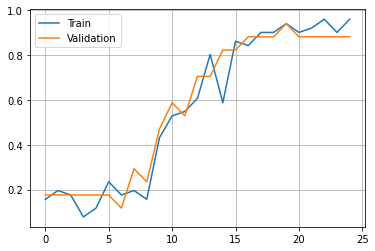

In [ ]:
plt.plot(trainAccs, label = 'Train')
plt.plot(valAccs, label = 'Validation')
plt.legend()
plt.grid(which = 'both')

# Test on Unseen Data

In [ ]:
testLoss, testAcc = runOneEpoch(False, xTest, yTest, baselineModel, optimizer, device)
print('Test Accuracy = %.4f' % (testAcc))

Test Accuracy = 0.8824
